# 사용 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
import argparse
import easydict
from torch import autograd

In [3]:
from torch.utils import data
from torchvision import datasets, transforms
import os

# 데이터 로드

In [4]:
total = pd.read_csv('./data/한국가스공사_시간별 공급량_20181231.csv', encoding='cp949')

In [5]:
total.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,A,2497.129
1,2013-01-01,2,A,2363.265
2,2013-01-01,3,A,2258.505
3,2013-01-01,4,A,2243.969
4,2013-01-01,5,A,2344.105


In [6]:
print(total.shape)

(368088, 4)


In [7]:
total.isnull().sum()

연월일    0
시간     0
구분     0
공급량    0
dtype: int64

# 전처리

In [8]:
total['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [9]:
d_map = {}
for i, d in enumerate(total['구분'].unique()):
    d_map[d] = i
total['구분'] = total['구분'].map(d_map) # 이 과정은 A~H 까지의 알파벳을 숫자로 매핑(대치)시키는 과정

In [10]:
total['구분']

0         0
1         0
2         0
3         0
4         0
         ..
368083    6
368084    6
368085    6
368086    6
368087    6
Name: 구분, Length: 368088, dtype: int64

In [11]:
d_map

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'G': 5, 'H': 6}

In [12]:
total['연월일'] = pd.to_datetime(total['연월일']) # 시계열 데이터로

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "/USER/d2coding.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

findfont: Font family ['D2Coding'] not found. Falling back to DejaVu Sans.


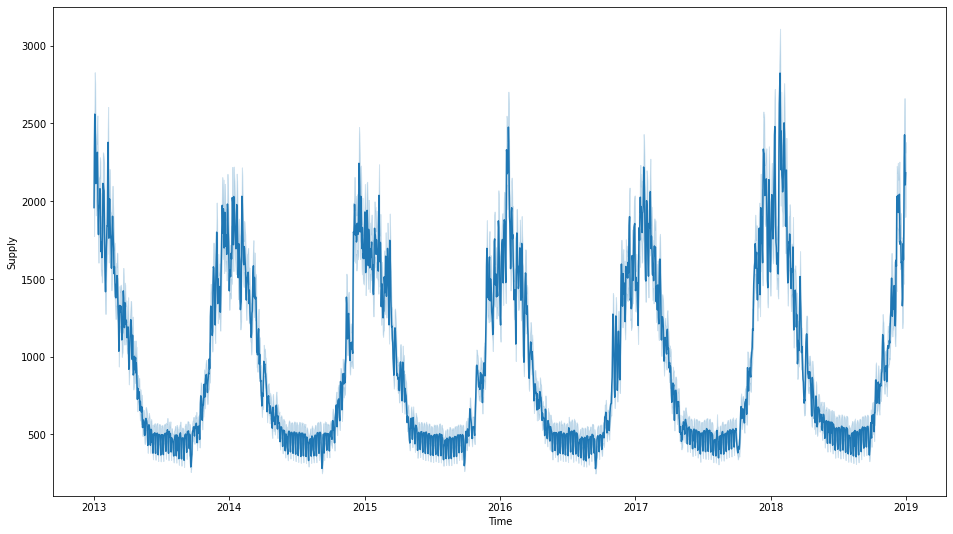

In [14]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=total['공급량'], x=total['연월일'])
plt.xlabel('Time')
plt.ylabel('Supply')
plt.show()

In [ ]:
# 이를 통해 매 겨울 시기에 공급량이 많았다는 것을 알 수 있다. 

In [ ]:
# total['year'] = total['연월일'].dt.year
# total['month'] = total['연월일'].dt.month
# total['day'] = total['연월일'].dt.day
# total['weekday'] = total['연월일'].dt.weekday

In [15]:
total

,연월일,시간,구분,공급량
0,2013-01-01,1,0,2497.129
1,2013-01-01,2,0,2363.265
2,2013-01-01,3,0,2258.505
3,2013-01-01,4,0,2243.969
4,2013-01-01,5,0,2344.105
...,...,...,...,...
368083,2018-12-31,20,6,681.033
368084,2018-12-31,21,6,669.961
368085,2018-12-31,22,6,657.941
368086,2018-12-31,23,6,610.953


In [18]:
# 연속형 변수인 공급량 컬럼은 따로 drop 하자
scale_cols = ['공급량']
cont_var = total[scale_cols]
# total.drop(columns=['공급량'], inplace=True)
etc = total.drop(columns=['공급량'])
print(cont_var)
print(etc)

             공급량
0       2497.129
1       2363.265
2       2258.505
3       2243.969
4       2344.105
...          ...
368083   681.033
368084   669.961
368085   657.941
368086   610.953
368087   560.896

[368088 rows x 1 columns]
              연월일  시간  구분
0      2013-01-01   1   0
1      2013-01-01   2   0
2      2013-01-01   3   0
3      2013-01-01   4   0
4      2013-01-01   5   0
...           ...  ..  ..
368083 2018-12-31  20   6
368084 2018-12-31  21   6
368085 2018-12-31  22   6
368086 2018-12-31  23   6
368087 2018-12-31  24   6

[368088 rows x 3 columns]


In [19]:
# 데이터 정규화: continuous variable
from sklearn.preprocessing import MinMaxScaler

cont_var.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(cont_var)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled

,공급량
0,0.215295
1,0.203747
2,0.194710
3,0.193456
4,0.202094
...,...
368083,0.058630
368084,0.057675
368085,0.056638
368086,0.052585


In [20]:
total = pd.concat([etc,df_scaled], axis=1)
total

,연월일,시간,구분,공급량
0,2013-01-01,1,0,0.215295
1,2013-01-01,2,0,0.203747
2,2013-01-01,3,0,0.194710
3,2013-01-01,4,0,0.193456
4,2013-01-01,5,0,0.202094
...,...,...,...,...
368083,2018-12-31,20,6,0.058630
368084,2018-12-31,21,6,0.057675
368085,2018-12-31,22,6,0.056638
368086,2018-12-31,23,6,0.052585


In [21]:
train_years = [2013,2014,2015,2016,2017]
val_years = [2018]

In [26]:
# train = total[total['year'].isin(train_years)]
# val = total[total['year'].isin(val_years)]
train = total[total['연월일'].dt.year.isin(train_years)]
val = total[total['연월일'].dt.year.isin(val_years)]

In [27]:
train.head()

,연월일,시간,구분,공급량
0,2013-01-01,1,0,0.215295
1,2013-01-01,2,0,0.203747
2,2013-01-01,3,0,0.194710
3,2013-01-01,4,0,0.193456
4,2013-01-01,5,0,0.202094


In [28]:
val

,연월일,시간,구분,공급량
306768,2018-01-01,1,0,0.152139
306769,2018-01-01,2,0,0.144735
306770,2018-01-01,3,0,0.138843
306771,2018-01-01,4,0,0.138260
306772,2018-01-01,5,0,0.147524
...,...,...,...,...
368083,2018-12-31,20,6,0.058630
368084,2018-12-31,21,6,0.057675
368085,2018-12-31,22,6,0.056638
368086,2018-12-31,23,6,0.052585


In [33]:
# features = ['구분', 'month', 'day', 'weekday', '시간']
features = ['구분', '연월일', '시간']
train_x = train[features]
train_y = train[['공급량']]

val_x = val[features]
val_y = val[['공급량']]

In [39]:
train_x.shape, train_y.shape

((306768, 3), (306768, 1))

In [40]:
train_x = np.array(train_x)

In [41]:
train_x

array([[0, Timestamp('2013-01-01 00:00:00'), 1],
       [0, Timestamp('2013-01-01 00:00:00'), 2],
       [0, Timestamp('2013-01-01 00:00:00'), 3],
       ...,
       [6, Timestamp('2017-12-31 00:00:00'), 22],
       [6, Timestamp('2017-12-31 00:00:00'), 23],
       [6, Timestamp('2017-12-31 00:00:00'), 24]], dtype=object)

In [42]:
train_y = np.array(train_y)
val_x = np.array(val_x)
val_y = np.array(val_y)

# 학습

In [30]:
# d_train = lgb.Dataset(train_x, train_y)
# d_val = lgb.Dataset(val_x, val_y)

# params = {
#     'objective': 'regression',
#     'metric':'mae',
#     'seed':42
# }

# model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=50)

In [37]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(len(train_years), train_x.shape[1]), 
               activation='relu', 
               return_sequences=False)
          )

model.add(Dense(1))

In [43]:
import os

model.compile(loss='mean_absolute_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(train_x, train_y, 
                                    epochs=300, 
                                    batch_size=16,
                                    validation_data=(val_x, val_y), 
                                    callbacks=[early_stop, checkpoint])

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

# 추론 및 결과 제출

In [ ]:
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
test.head()

In [ ]:
submission.head()

In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [ ]:
test['구분'] = test['구분'].map(d_map)

In [ ]:
test_x = test[features]

In [ ]:
test_x

In [ ]:
preds = model.predict(test_x)

In [ ]:
submission['공급량'] = preds

In [ ]:
submission.to_csv('baseline.csv', index=False)